In [1]:
%matplotlib inline
import sys
from urllib2 import Request, urlopen, URLError
import requests
import time
from pyproj import Proj
p1 = Proj(init='epsg:26915')
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # makes plots pretty
import pandas as pd
import numpy as np
from xml.etree import cElementTree as ET
import re

from sql import *
import sqlite3

from matplotlib import dates, pyplot
import pytz
import datetime as DT
from datetime import datetime

import pylab as pl
from IPython import display
#matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

Automated script requests all vehicle locations for all bus routes every minute. This data gets dumped into a local SQL database for querying later, and for historical bus locations. 

In [2]:
conAPI =  sqlite3.connect('API_Scrape_nopdist.db')
query = '''SELECT * FROM API_DAT'''
API_test = pd.read_sql_query(query, conAPI)
print 'NUMBER OF ENTRIES IS ' +str(len(API_test))
print API_test.head()


NUMBER OF ENTRIES IS 607630
             sd rt   id              x               y               t  hdg  \
0  201602052058  1   75  946223.743458  4648948.625806  20160205 14:57  358   
1  201602052058  1   74  945083.173574  4650114.740172  20160205 14:57  182   
2  201602052058  3  152  947936.149141  4634409.329609  20160205 14:57    1   
3  201602052058  3  151  947670.481620  4637748.393779  20160205 14:58  359   
4  201602052058  3  149  947533.667538  4639484.582599  20160205 14:58  356   

    pid  dly  
0  6353    0  
1  6353    0  
2  5342    0  
3  5342    0  
4  5342    0  


An additional script runs every hour and checks if any vehicles in the full database have associated pattern IDs which haven't been seen before. If so, it runs additional queries, also in batches every minute, to get the pattern description and saves it locally.

In [3]:
conStop =  sqlite3.connect('Pattern_Stops.db')
pid = API_test[API_test['rt'] == '66']['pid'].iloc[0]
query = '''SELECT * FROM PAT_STOPS'''
Stops_test = pd.read_sql_query(query, conStop)
print 'NUMBER OF ENTRIES IS ' +str(len(Stops_test['pid'].unique()))
print Stops_test[Stops_test['pid']==pid][['rtdir', 'typ', 'stpid', 'stpnm', 'pdist']]

NUMBER OF ENTRIES IS 772
           rtdir typ  stpid                        stpnm     pdist
24209  Eastbound   S  14514            Chicago & Kostner       0.0
24210  Eastbound   S    527            Chicago & Kildare     513.0
24211  Eastbound   S    528             Chicago & Keeler    1153.0
24212  Eastbound   S    529             Chicago & Karlov    1859.0
24213  Eastbound   S    530            Chicago & Pulaski    2521.0
24214  Eastbound   S    531        Chicago & Springfield    3198.0
24215  Eastbound   S  14515             Chicago & Hamlin    3984.0
24216  Eastbound   S  15133           Chicago & Lawndale    4656.0
24217  Eastbound   S  14516       Chicago & Central Park    5320.0
24218  Eastbound   S    535          Chicago & St. Louis    5825.0
24219  Eastbound   S  14517              Chicago & Homan    6634.0
24220  Eastbound   S    537          Chicago & Spaulding    7134.0
24221  Eastbound   S    538             Chicago & Kedzie    7793.0
24222  Eastbound   S    540         C

In addition to saving all of the historial data, a single database also stores only the most recently seen vehicles, so if one wanted to show only active buses, a SQL query doesn't have to be made on the full database.

In [4]:
conAPI =  sqlite3.connect('API_curr.db')

query = '''SELECT rt, COUNT() as count FROM (SELECT rt, id as count FROM API_DAT GROUP BY rt, id) GROUP BY rt'''
query = '''SELECT * FROM API_CURR_DAT'''
API_test = pd.read_sql_query(query, conAPI)
print 'NUMBER OF BUSES IS ' + str(len(API_test))
print API_test.head()

NUMBER OF BUSES IS 1091
             sd rt       id              x               y               t  \
0  201602110013  1       69  945874.433160  4650230.297911  20160210 18:25   
1  201602110000  1       68  946224.098357  4648811.333622  20160210 18:25   
2  201602110016  1       89  946349.363477  4647404.055875  20160210 18:22   
3  201602110024  2       57  946795.930212  4651811.835245  20160210 18:25   
4  201602102348  2  1012938  945778.150126  4651189.414653  20160210 18:25   

             lt       spd  hdg   pid  dly  pdist  
0  201602110025      2.12   89  6351    0   4619  
1  201602110025  5.233333  175  6351    0  10178  
2  201602110025       NaN  358  6353    0   8015  
3  201602110025  10.96667  268  5528    0   1541  
4  201602110025       NaN  268  5528    0   7345  


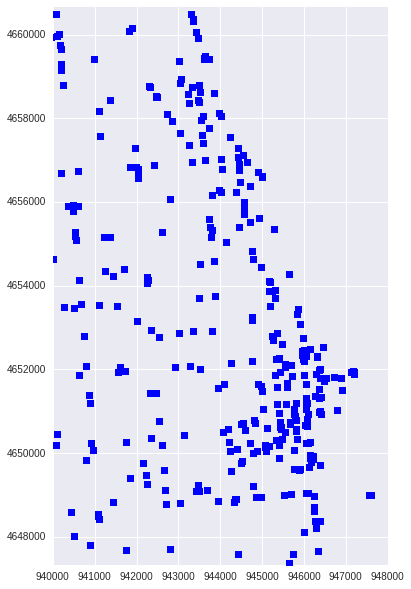

In [ ]:
f = plt.figure(figsize = (6, 10))


plt.axis('equal')
axes = plt.gca()
axes.set_xlim([940000,948000])
axes.set_ylim([4650000,4658000])
j = 0
c = 'b'
while True:
    conAPI =  sqlite3.connect('API_curr.db')

    query = '''SELECT * FROM API_CURR_DAT'''
    API_test1 = pd.read_sql_query(query, conAPI)
    if j==0:
        j = j+1
        API_test = API_test1
    else:
        time.sleep(2.5)
        API_test2 = pd.read_sql_query(query, conAPI)
    
        if len(API_test1)> len(API_test2):
            API_test = API_test1
        else:
            API_test = API_test2
    plt.gca().cla() 
    axes.set_xlim([940000,948000])
    axes.set_ylim([4650000,4658000])

    plt.plot(API_test['x'], API_test['y'], c+'s')
    if c == 'b':
        c = 'r'
    else:
        c = 'b'
    
    display.clear_output(wait=True)
    display.display(plt.gcf()) 

